In [1]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import resource
import time
from datetime import datetime
import math
import os
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential

In [2]:
## Preprocessing of data
# #Split dataset to 10 partitions
N = 60000
M = 10000

num_workers = 10 #Number of subsets/workers
num_classes = 10
image_size = 784
numSamples = N//num_workers #Training samples available for each worker node

(x_train, y_train), (x_test, y_test) = mnist.load_data() # Loading the data here

image_size = 784

x_train = x_train.reshape(x_train.shape[0], image_size).T
x_test = x_test.reshape(x_test.shape[0], image_size).T

X = {}
Y = {}

for idx in range(num_workers):
    X[idx] = x_train[:, idx*numSamples: (idx+1)* numSamples]
    Y[idx] = y_train[idx* numSamples: (idx+1)* numSamples]

11490434/11490434 [==============================] - 1s 0us/step


In [3]:
#binary SVM classification one-vs-rest loss and its gradient

def bin_SVM_classify(x, w):
    scores = np.matmul(x.T, w)
    print(scores.shape)
    scores = np.matmul(x.T, w)
    class_votes = np.zeros(scores.shape)
    class_votes[scores > 0] += 1
    for i in range(10):
        class_votes[scores[:,i] <= 0,:] += 1
    class_votes[scores <= 0] -= 1
    #return np.argmax(class_votes, axis = 1).reshape(x.shape[1], 1)
    return np.argmax(scores, axis = 1)

            
def bin_SVM_cost(x, y, w):
    svm_cost = - np.matmul(x.T, w) 
    svm_cost[(range(y.shape[0]), y.reshape(y.shape[0]))] *= -1
    return (1 - svm_cost).clip(min = 0)


def bin_regulated_total_cost(x, y, w, lambda_):
    return bin_SVM_cost(x, y, w).sum(axis = 1) + lambda_/2 * np.linalg.norm(w, axis = 1)**2


def bin_SVM_cost_grad(x, y, w, lambda_):
    svm_cost = bin_SVM_cost(x, y, w)
    svm_cost[svm_cost > 0] = 1
    svm_cost_grad = np.zeros((x.shape[0], 10))
    for i in range(10):
        svm_cost_yi = svm_cost[:, i]
        svm_cost_yi[y == i] *= -1
        svm_cost_grad[:, i] = np.multiply(x, svm_cost_yi).sum(axis = 1) + lambda_ * w[:, i]
    return svm_cost_grad

def bin_SVM_class_err(x,y,w):
    y_estimate = bin_SVM_classify(x, w)
    return sum(y_estimate != y)*100/len(y)



In [4]:
## CA5---------------------------- Part (a)------------------------------------------------------------------------------

#Each worker computes 10 svm loss gradients based w.r.t w for 10 classes for its partition of data adding noise with probability p :
def decentralized_gradient_descent_worker(x, y, w_k, lambda_):
    delta = 0;
    ## compute the gradients ----------------------------------------
    return bin_SVM_cost_grad(x, y, w_k, lambda_) #train the weights for class i
        
def decentralized_gradient_descent_worker_(args):
    return decentralized_gradient_descent_worker(*args)

#DGD
def decentralized_gradient_descent(x, y, lambda_, learning_rate, max_iter):
    #each class has a w_k
    w_k = np.random.rand(x.shape[0], 10)
    T = 0
    training_errors = []    
    test_errors = []

    for i in range(max_iter):  
        workers_w_k = np.array(10 *[w_k]).reshape(10, x.shape[0], 10)
        grad_w = np.zeros([x.shape[0],num_classes])
        
        for idx in range(num_workers):
            dgdw = decentralized_gradient_descent_worker(X[idx], Y[idx], workers_w_k[idx,:,:], lambda_)

            grad_w = grad_w + dgdw                    
        grad_w = grad_w/N
        
        w_k = w_k - learning_rate * grad_w

        training_errors.append(bin_SVM_class_err(x_train,y_train,w_k))        
        test_errors.append(bin_SVM_class_err(x_test,y_test,w_k))

    return w_k.reshape(x.shape[0],10), training_errors, test_errors

(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(10000, 10)
(60000, 10)
(100

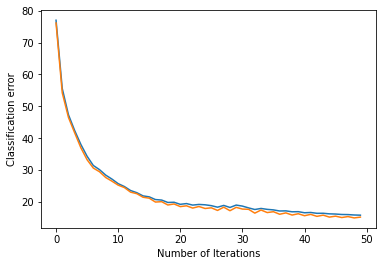

In [5]:
max_iter = 50
lambda_ = 1
learning_rate = 0.005

start = time.time() 

w, training_errors, test_errors = decentralized_gradient_descent(x_train, y_train, lambda_, learning_rate, max_iter)  

end = time.time()
print('time=',end-start,' seconds')
plt.plot(range(max_iter), training_errors)
plt.plot(range(max_iter), test_errors)
plt.xlabel("Number of Iterations")
plt.ylabel("Classification error")
print(max(test_errors))
print(min(test_errors))

In [6]:
## CA5---------------------------- Part (b)------------------------------------------------------------------------------
#Graph for 2 star topology
# Complete communication graph -----------------------
A = np.identity(num_workers)*(5/6)
A[4,0:6] = 1/6
A[5,5:10] = 1/6
A[0:6,4] = 1/6
A[5:10,5] = 1/6
print(A)

[[0.83333333 0.         0.         0.         0.16666667 0.
  0.         0.         0.         0.        ]
 [0.         0.83333333 0.         0.         0.16666667 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.83333333 0.         0.16666667 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.83333333 0.16666667 0.
  0.         0.         0.         0.        ]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.         0.         0.         0.16666667
  0.83333333 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.16666667
  0.         0.83333333 0.         0.        ]
 [0.         0.         0.         0.         0.         0.16666667
  0.         0.         0.83333333 0.       

In [7]:
def decentralized_gradient_descent_worker(x, y, w_k, lambda_):
        return bin_SVM_cost_grad(x, y, w_k, lambda_)

def decentralized_gradient_descent(x,y,lambda_,learn_rate,max_iter):
    workers_w_k_new = np.random.rand(10,x.shape[0], 10)
    workers_w_k_old= np.random.rand(10,x.shape[0], 10)

    T = 0
    Train_error_W1 = []
    Train_error_W5 = []  
    Test_error_W1 = []
    Test_error_W5 = []  

    for i in range(max_iter):  

        grad_w = np.zeros([x.shape[0],num_classes])
        
        for j in range(num_workers):
            #Worker j initially attempts consensus utilizing communication graph A and subsequently updates its gradient
            workers_w_k_new[j,:,:] = np.average(workers_w_k_old, axis=0, weights=A[j,:])
            dgdw = decentralized_gradient_descent_worker(X[j], Y[j], workers_w_k_new[j,:,:], lambda_) #Gradient update
            workers_w_k_new[j,:,:] = workers_w_k_new[j,:,:] - learn_rate * dgdw/numSamples
        
        Test_error_W1.append(bin_SVM_class_err(x_test, y_test, workers_w_k_new[0,:,:]))        
        Test_error_W5.append(bin_SVM_class_err(x_test, y_test, workers_w_k_new[4,:,:]))
        
        Train_error_W1.append(bin_SVM_class_err(X[0], Y[0], workers_w_k_new[0,:,:]))
        
        Train_error_W5.append(bin_SVM_class_err(X[4], Y[4], workers_w_k_new[4,:,:]))        

        workers_w_k_old = workers_w_k_new

    return workers_w_k_new, Train_error_W1, Train_error_W5, Test_error_W1, Test_error_W5

#Intializing the parameters

max_iter = 50
lambda_ = 1
learn_rate = 0.005

start = time.time() 
w, Train_error_W1, Train_error_W5, Test_error_W1, Test_error_W5 = decentralized_gradient_descent(x_train,y_train,lambda_,learn_rate,max_iter)  
end = time.time()
print('time=',end-start,' seconds')    

(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)
(6000, 10)
(10000, 10)
(10000, 10)
(6000, 10)

The Number of signalling exchanges for every iteration of the Decentralized Sub-Gradient method equals: 

$$2\sum_i \text{deg}(\text{Node } i) = \text{num. of non-zero non-diagonal entries }A,$$ = 18 for a 2 star topology communication graph

61.31
13.93


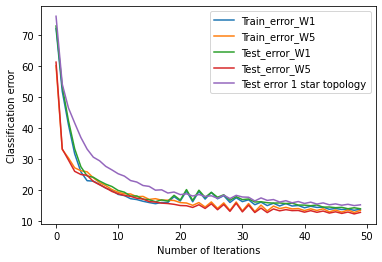

In [8]:
plt.plot(range(max_iter), Train_error_W1)
plt.plot(range(max_iter), Train_error_W5)
plt.plot(range(max_iter), Test_error_W1)
plt.plot(range(max_iter), Test_error_W5)
plt.plot(range(max_iter), test_errors)
plt.xlabel("Number of Iterations")
plt.ylabel("Classification error")


print(max(Test_error_W5))
print(min(Test_error_W1))
plt.legend(['Train_error_W1','Train_error_W5', 'Test_error_W1', 'Test_error_W5', 'Test error 1 star topology'],fontsize=10)


We can select the master node as the most critical node in the star topology framework (Algo 1) but other workers could be selected too by adjusting their weights.

In the 2 star topology network, nodes 5 and 6 are the most crucial to protect since it is these nodes which initialize the 2 respective stars

In [9]:
## CA6---------------------------- Part (a)------------------------------------------------------------------------------

# Complete Q1 and Q2 compression functions here -----------------------

# Repeat part a-b from CA5 using Q1 and Q2 compression functions here -----------------------
